Estudo parametrico de um algoritmo imunológico em um problema de classificação

In [ ]:
# Separar em 10 pastas de tamanho igual (15)

# 9 para treino e 1 para teste

# 10 execuções

# Cada execução testo numa nova pasta (decremental)

# Média e desvio padrão dos 10 testes

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install matplotlib

In [ ]:
import numpy as np
from numpy import random
import clonalg
import pandas as pd
from sklearn import preprocessing

Anticorpos treinados com exemplos de iris virginica [label 2]

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

#Train dataset
train = train.join(labels)
# O valor de train[4] define qual label será utilizada para o treino da população
train = train.loc[train[4] == 0]
train = train.drop(columns=[4])

Métodos de normalização além do StandartScaler deverão ser testados

In [ ]:
feature_num = len(train.axes[1])
feature_max = train.max()
feature_max  = feature_max.max()
feature_min = train.min()
feature_min  = feature_min.min()

Definição de hiperparâmetros

In [ ]:
population_size = 400
selection_size = 50
memory_set_percentage = 50

clone_rate = 40 ## Clone rate - 1 (Step 5 +-)
mutation_rate = 0.3
stop_codition = 100


d = 15 ## Individuos aleatorios - 2 (Step 2.5 +-)
sigma1 = 0.9
sigma2 = 0.3

Conversão de dataframe para numpy array

In [ ]:
train = train.to_numpy()

![](resources/V7zasui.png)

In [ ]:
 # 1. For each antigen do
    # 1.1 Determine its affinity to network cells
    # 1.2 Select the n highest affinity network cells
    # 1.3 Generate Nc clones from these n cells. The higher the affinity, the larger Nc;
    # 1.4 Apply hypermutation to the generated clones, with variability inversely proportional to the progenitor fitness 
    # 1.5 Determine the affinity among the antigen and all clones
    # 1.6 Keep only m% of the highest affinity mutated clones into the clone population
    # 1.7 Eliminate all clones but one whose affinity with the antigen is inferior to a predefined threshold sigma2 (apoptosis)
    # 1.8 Determine the affinity among all the mutated clonesand eliminate those whose affinity with each other is above a pre-defined threshold sigma1 (supression)
    # 1.9 Insert the remaining clones into the population
# 2. Determine the simillarity among all the antibodies and eliminate those with similarity above a threshold sigma1 (supression)
# 3. Introduce a d% of new randomly generated cells (random insertion)

In [ ]:
stop = 0
population = clonalg.create_random_cells(population_size, feature_num, feature_min, feature_max)

while stop != stop_codition:
    # 1. For each antigen do
    for antigen in train:
        # 1.1 Determine its affinity to network cells
        population_affinity = [(cell, clonalg.affinity(cell, antigen)) for cell in population]
        # 1.2 Select the n highest affinity network cells
        population_affinity = sorted(population_affinity, key=lambda x: abs(x[1]))
        best_affinity = population_affinity[:selection_size]
        # 1.3 Generate Nc clones from these n cells. The higher the affinity, the larger Nc;
        clone_population = []
        for cell in best_affinity:
            cell_clones = clonalg.clone(cell, clone_rate)
            clone_population += cell_clones
        # 1.4 Apply hypermutation to the generated clones, with variability inversely proportional to the progenitor fitness 
        # 1.5 Determine the affinity among the antigen and all clones
        mutaded_clone_population = []
        for cell in clone_population:
            mutated_clone = clonalg.hypermutate_variability(cell, mutation_rate, antigen)
            mutaded_clone_population.append(mutated_clone)
        # 1.6 Keep only m% of the highest affinity mutated clones into the clone population
        mutaded_clone_population.sort(key=lambda x: x[1])
        pop_size = round(len(clone_population)/100)*memory_set_percentage

        mutaded_clone_population = mutaded_clone_population[:pop_size]

        # 1.7 Eliminate all clones but one whose affinity with the antigen is inferior to a predefined threshold sigma2 (apoptosis)
        filtered_clone_population = list(filter(lambda x: x[1] < sigma2, mutaded_clone_population))

        # 1.8 Determine the affinity among all the mutated clonesand eliminate those whose affinity with each other is above a pre-defined threshold sigma1 (supression)
        remaining_clone_population = clonalg.remove_similar_clones(filtered_clone_population, sigma1)

        # 1.9 Insert the remaining clones into the populatuon
        # Remova o atributo de afinidade das células em remaining_clone_population
        remaining_clone_population_no_affinity = [(cell[0],) for cell in remaining_clone_population]
        # Adicione remaining_clone_population_no_affinity à população
        population = population + remaining_clone_population_no_affinity

    # 2.0 Determine the simillarity among all the antibodies and eliminate those with similarity above a threshold sigma1 (supression)
    population = clonalg.suppress_similar_cells(population, sigma1)

    # 3 Introduce a d% of new randomly generated cells (random insertion)
    new_cells = clonalg.create_random_cells(int(population_size * (d / 100)), feature_num, feature_min, feature_max)
    population += new_cells
    print("População: ", len(population), "     Iteração: ", stop)
    stop += 1

## Solução temporária para nested arrays nos indivíduos da população.

for i, cell in enumerate(population):
    # Verifica se a célula tem mais de uma dimensão
    if len(cell[0].shape) > 1:
        # Aplica numpy.ravel() para simplificar as dimensões
        flattened_cell = np.ravel(cell[0])
        population[i] = (flattened_cell,)
    else:
        population[i] = cell

    if isinstance(cell, tuple):
        array_cell = np.array(cell)
        flattened_cell = np.ravel(array_cell)
        population[i] = (flattened_cell)


In [ ]:
np.shape(population)

In [ ]:
for i, cell in enumerate(population):
    # Verifica se a célula tem mais de uma dimensão
    if len(cell[0].shape) > 1:
        # Aplica numpy.ravel() para simplificar as dimensões
        flattened_cell = np.ravel(cell[0])
        population[i] = (flattened_cell,)
    else:
        population[i] = cell
        
    if isinstance(cell, tuple):
        array_cell = np.array(cell)
        flattened_cell = np.ravel(array_cell)
        population[i] = (flattened_cell)

In [ ]:
antibodies = pd.DataFrame(population)
antibodies = pd.DataFrame(scaler.inverse_transform(antibodies), columns=antibodies.columns)
antibodies_array = antibodies.values

In [ ]:
antibodies

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA

# Extract the feature vectors from the population
feature_vectors = np.array(list(antibodies_array))


# Apply PCA to reduce the dimensionality to 3
pca = PCA(n_components=3)
reduced_population = pca.fit_transform(feature_vectors)

# Now, you can plot the reduced population using a 3D scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduced_population[:, 0]
y = reduced_population[:, 1]
z = reduced_population[:, 2]

ax.scatter(x, y, z)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

feature_vectors = np.array(list(antibodies_array))

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(df)

#Train dataset
train = train.join(labels)
train = train.loc[train[4] == 2]
train = train.drop(columns=[4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

train_array = train.values

feature_vectors = np.array(list(train_array))

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(df)

#Train dataset
train = train.join(labels)
train = train.loc[train[4] == 1]
train = train.drop(columns=[4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

train_array = train.values

feature_vectors = np.array(list(train_array))

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(df)

#Train dataset
train = train.join(labels)
train = train.loc[train[4] == 0]
train = train.drop(columns=[4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

train_array = train.values

feature_vectors = np.array(list(train_array))

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
import pandas as pd
from sklearn import preprocessing
from train_loop import train_ais_classifier

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)

In [ ]:
feature_num = train.shape[1] - 1  # Menos a coluna de labels
feature_min = train.iloc[:, :-1].min().min()  # Menos a coluna de labels
feature_max = train.iloc[:, :-1].max().max()  # Menos a coluna de labels

# Treine o classificador AIS para cada classe (0, 1, 2) e armazene os resultados em uma lista
trained_populations = []
for class_label in range(3):
    train_class = train.loc[train[4] == class_label]
    train_class = train_class.drop(columns=[4])
    train_class = train_class.to_numpy()
    population = train_ais_classifier(train_class, feature_num, feature_min, feature_max)
    trained_populations.append(population)

In [ ]:
from sklearn.model_selection import train_test_split
import clonalg
from train_loop import multiclass_performance_measure

df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)
# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(train, test_size=0.3, random_state=42)

test_data_array = test_data.values
performance = multiclass_performance_measure(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")


Multithread

In [ ]:
from train_loop import train_clonalg_parallel
from train_loop import multiclass_performance_measure_v2
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)
# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(train, test_size=0.3, random_state=82)

params = {
    'population_size': 100,
    'selection_size': 20,
    'memory_set_percentage': 15,
    'clone_rate': 10,
    'mutation_rate': 0.3,
    'stop_condition': 10,
    'd': 5,
    'sigma1': 0.98,
    'sigma2': 0.8,
    'feature_num': train_data.shape[1] - 1,
    'feature_min': train_data.min().min(),
    'feature_max': train_data.max().max(),
}

trained_populations = train_clonalg_parallel(train_data, params, [0, 1, 2])

# Avaliar o desempenho do classificador AIS
test_data_array = test_data.values
performance, ltrue, lpredict = multiclass_performance_measure_v2(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")
print(lpredict)
print(ltrue)

In [ ]:
test_data_array

In [ ]:
import clonalg

example = [0.19444444, 0.625     , 0.10169492, 0.20833333]
highest1 = []
highest2 = []
highest3 = []

for cell in trained_populations[0]:
    highest1.append(clonalg.affinity(example, cell))
print(np.sort(highest1))

for cell in trained_populations[1]:
    highest2.append(clonalg.affinity(example, cell))
print(np.sort(highest2))

for cell in trained_populations[2]:
    highest3.append(clonalg.affinity(example, cell))
print(np.sort(highest3))

In [ ]:
for i in range (3):
    trained_populations[i] = scaler.inverse_transform(trained_populations[i])

test_data_test = pd.DataFrame(test_data_array)
labels = test_data_test[[4]].copy()
test_data_test= test_data_test.drop(columns=[4])
test_data_test = pd.DataFrame(scaler.inverse_transform(test_data_test.values), columns=test_data_test.columns, index=test_data_test.index)
test_data_test = test_data_test.join(labels)
test_data_array= test_data_test.values

In [ ]:
performance, ltrue, lpredict = multiclass_performance_measure_v2(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")
print(lpredict)
print(ltrue)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from train_loop import multiclass_performance_measure_v2
from train_loop import train_clonalg_parallel
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)

# Crie um objeto KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Armazenar as métricas de desempenho de cada iteração
performance_scores = []
# Armazenar todas as verdadeiras e previstas etiquetas através das divisões
all_true_labels = []
all_predicted_labels = []

train_data, test_data = train_test_split(train, test_size=0.3, random_state=42)

params = {
    'population_size': 100,
    'selection_size': 15,
    'memory_set_percentage': 15,
    'clone_rate': 10,
    'mutation_rate': 0.3,
    'stop_condition': 5,
    'd': 10,
    'sigma1': 0.8,
    'sigma2': 0.7,
    'feature_num': train_data.shape[1] - 1,
    'feature_min': train_data.min().min(),
    'feature_max': train_data.max().max(),
}

# Loop através das divisões de treinamento e teste
for i, (train_index, test_index) in enumerate(kfold.split(train), start=1):
    # Dividir o conjunto de dados em treinamento e teste com base nos índices
    train_data = train.iloc[train_index]
    test_data = train.iloc[test_index]

    # Treinar o classificador AIS
    trained_populations = train_clonalg_parallel(train_data, params, [0, 1, 2])

    # Avaliar o desempenho do classificador AIS
    test_data_array = test_data.values
    accuracy, true_labels, predicted_labels = multiclass_performance_measure_v2(trained_populations, test_data_array)
    performance_scores.append(accuracy)

    # Estender all_true_labels e all_predicted_labels com os rótulos verdadeiros e previstos da iteração atual
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

    # Imprimir o relatório de classificação para a iteração atual
    print("\n//////////////////////////////////////////////\n")
    print(f"Relatório de classificação para a pasta {i}:")
    print(classification_report(true_labels, predicted_labels))
    print("\n//////////////////////////////////////////////\n")

# Calcular a precisão média
print("\n//////////////////////////////////////////////\n")
mean_accuracy = np.mean(performance_scores)
print(f"Desempenho médio do classificador AIS: {mean_accuracy * 100:.2f}%")
print("\n//////////////////////////////////////////////\n")

# Calcular e exibir a matriz de confusão combinada
print("\n//////////////////////////////////////////////\n")
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Matriz de confusão:")
print(conf_matrix)
print("\n//////////////////////////////////////////////\n")

# Calcular e exibir o relatório de classificação combinado
print("\n//////////////////////////////////////////////\n")
class_report = classification_report(all_true_labels, all_predicted_labels)
print("Relatório de classificação:")
print(class_report)
print("\n//////////////////////////////////////////////\n")


In [ ]:
from train_loop import train_clonalg_parallel
from train_loop import multiclass_performance_measure_v2
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('dataset/wine.csv', header=None)

labels = df[[0]].copy()

df = df.drop(columns=[0])

# Standard Scaler
scaler = preprocessing.MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)
# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(train, test_size=0.3, random_state=52)

params = {
    'population_size': 40,
    'selection_size': 15,
    'memory_set_percentage': 15,
    'clone_rate': 25,
    'mutation_rate': 0.3,
    'stop_condition': 5,
    'd': 15,
    'sigma1': 0.95,
    'sigma2': 0.5,
    'feature_num': train_data.shape[1] - 1,
    'feature_min': train_data.min().min(),
    'feature_max': train_data.max().max(),
}

trained_populations = train_clonalg_parallel(train_data, params, [1, 2, 3])

# Avaliar o desempenho do classificador AIS
test_data_array = test_data.values
performance, ltrue, lpredict = multiclass_performance_measure_v2(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")
print(lpredict)
print(ltrue)

In [ ]:
from train_loop import multiclass_performance_measure_v2

test_data_array = test_data.values
performance, ltrue, lpredict = multiclass_performance_measure_v2(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")
print(lpredict)
print(ltrue)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from train_loop import train_clonalg_parallel
from train_loop import multiclass_performance_measure_v2

# Criar um conjunto de dados com 3 clusters bem separados
X, y = make_blobs(n_samples=300, centers=3, random_state=42)

# Converter os arrays em um DataFrame
df = pd.DataFrame(np.column_stack((X, y)))

# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(df, test_size=0.3)

params = {
    'population_size': 200,
    'selection_size': 30,
    'memory_set_percentage': 20,
    'clone_rate': 25,
    'mutation_rate': 0.3,
    'stop_condition': 200,
    'd': 5,
    'sigma1': 0.95,
    'sigma2': 0.6,
    'feature_num': train_data.shape[1] - 1,
    'feature_min': train_data.min().min(),
    'feature_max': train_data.max().max(),
}

trained_populations = train_clonalg_parallel(train_data, params, [0, 1, 2])

# Avaliar o desempenho do classificador AIS
test_data_array = test_data.values
performance, ltrue, lpredict = multiclass_performance_measure_v2(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")
print(lpredict)
print(ltrue)


In [ ]:
import matplotlib.pyplot as plt

def plot_antibody_populations(trained_populations, colors=['r', 'g', 'b'], markers=['o', '^', 's']):
    for i, population in enumerate(trained_populations):
        antibody_coordinates = [cell for cell in population]
        x_coordinates = [coord[0] for coord in antibody_coordinates]
        y_coordinates = [coord[1] for coord in antibody_coordinates]
        plt.scatter(x_coordinates, y_coordinates, color=colors[i], marker=markers[i], label=f"Population {i}")

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Antibody Populations')
    plt.legend()
    plt.show()

plot_antibody_populations(trained_populations)


In [ ]:
print(trained_populations[0][0])

In [ ]:
import clonalg
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Criar um conjunto de dados com 3 clusters bem separados
X, y = make_blobs(n_samples=300, centers=3, random_state=42)

# Converter os arrays em um DataFrame
df = pd.DataFrame(np.column_stack((X, y)))

# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(df, test_size=0.3)

train_data = train_data.to_numpy()

labels = df[[2]].copy()

df = df.drop(columns=[2])

#Standard Scaler
scaler = preprocessing.MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

#Train dataset
train = train.join(labels)
# O valor de train[4] define qual label será utilizada para o treino da população
train = train.loc[train[2] == 2]
train = train.drop(columns=[2])

População:  76      Iteração:  0
População:  96      Iteração:  1
População:  105      Iteração:  2
População:  116      Iteração:  3
População:  118      Iteração:  4
População:  119      Iteração:  5
População:  122      Iteração:  6
População:  128      Iteração:  7
População:  123      Iteração:  8
População:  119      Iteração:  9


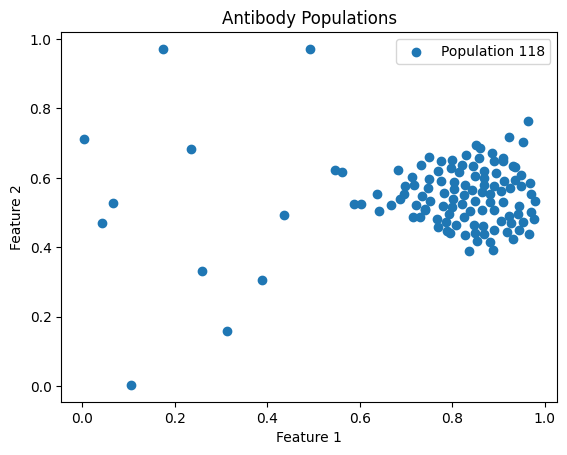

In [4]:
import clonalg
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Criar um conjunto de dados com 3 clusters bem separados
X, y = make_blobs(n_samples=100, centers=3, random_state=42)

# Converter os arrays em um DataFrame
df = pd.DataFrame(np.column_stack((X, y)))

# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(df, test_size=0.3)

train_data = train_data.to_numpy()

labels = df[[2]].copy()

df = df.drop(columns=[2])

#Standard Scaler
scaler = preprocessing.MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

#Train dataset
train = train.join(labels)
# O valor de train[4] define qual label será utilizada para o treino da população
train = train.loc[train[2] == 1]
train = train.drop(columns=[2])

train = train.to_numpy()

population_size = 60
selection_size = 15
memory_set_percentage = 15
clone_rate = 10
mutation_rate = 0.3
stop_condition = 10
d = 10
sigma1 = 0.98
sigma2 = 0.8
feature_num = train_data.shape[1] - 1
feature_min = train_data.min().min()
feature_max = train_data.max().max()

stop = 0
population = clonalg.create_random_cells(population_size, feature_num, feature_min, feature_max)

while stop != stop_condition:
    # 1. For each antigen do
    for antigen in train:
        # 1.1 Determine its affinity to network cells
        population_affinity = [(cell, clonalg.affinity(cell, antigen)) for cell in population]
        # 1.2 Select the n highest affinity network cells
        population_affinity = sorted(population_affinity, key=lambda x: abs(x[1]))
        best_affinity = population_affinity[selection_size:]
        # 1.3 Generate Nc clones from these n cells. The higher the affinity, the larger Nc;
        clone_population = []
        for cell in best_affinity:
            cell_clones = clonalg.clone(cell, clone_rate)
            clone_population += cell_clones
        # 1.4 Apply hypermutation to the generated clones, with variability inversely proportional to the progenitor fitness 
        # 1.5 Determine the affinity among the antigen and all clones
        mutaded_clone_population = []
        for cell in clone_population:
            mutated_clone = clonalg.hypermutate_variability(cell, mutation_rate, antigen)
            mutaded_clone_population.append(mutated_clone)
        # 1.6 Keep only m% of the highest affinity mutated clones into the clone population
        mutaded_clone_population.sort(key=lambda x: x[1])
        pop_size = round(len(clone_population)/100)*memory_set_percentage

        mutaded_clone_population = mutaded_clone_population[pop_size:]
        # 1.7 Eliminate all clones but one whose affinity with the antigen is inferior to a predefined threshold sigma2 (apoptosis)
        filtered_clone_population = list(filter(lambda x: x[1] > sigma2, mutaded_clone_population))
        # 1.8 Determine the affinity among all the mutated clonesand eliminate those whose affinity with each other is above a pre-defined threshold sigma1 (supression)
        remaining_clone_population = clonalg.remove_similar_clones(filtered_clone_population, sigma1)

#         # 1.9 Insert the remaining clones into the populatuon
#         # Remova o atributo de afinidade das células em remaining_clone_population
        remaining_clone_population_no_affinity = [(cell[0],) for cell in remaining_clone_population]
#         # Adicione remaining_clone_population_no_affinity à população
        population = population + remaining_clone_population_no_affinity

# 2.0 Determine the simillarity among all the antibodies and eliminate those with similarity above a threshold sigma1 (supression)
    population = clonalg.remove_similar_clones(population, sigma1)

# 3 Introduce a d% of new randomly generated cells (random insertion)
    if(stop != stop_condition-1):
        new_cells = clonalg.create_random_cells(int(population_size * (d / 100)), feature_num, feature_min, feature_max)
        population += new_cells

    for i, cell in enumerate(population):
        # Verifica se a célula tem mais de uma dimensão
        if len(cell[0].shape) > 1:
            # Aplica numpy.ravel() para simplificar as dimensões
            flattened_cell = np.ravel(cell[0])
            population[i] = (flattened_cell,)
        else:
            population[i] = cell

        if isinstance(cell, tuple):
            array_cell = np.array(cell)
            flattened_cell = np.ravel(array_cell)
            population[i] = (flattened_cell)

    print("População: ", len(population), "     Iteração: ", stop)
    stop += 1


import matplotlib.pyplot as plt


antibody_coordinates = [cell for cell in population]
x_coordinates = [coord[0] for coord in antibody_coordinates]
y_coordinates = [coord[1] for coord in antibody_coordinates]
plt.scatter(x_coordinates, y_coordinates, label=f"Population {i}")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Antibody Populations')
plt.legend()
plt.show()


In [ ]:
stop = 0
population = clonalg.create_random_cells(population_size, feature_num, feature_min, feature_max)
population = [np.array(cell) for cell in population]

while stop != stop_condition:
    # 1. For each antigen do
    for index, antigen_row in train.iterrows():
        antigen = antigen_row.to_numpy()
        # 1.1 Determine its affinity to network cells
        population_affinity = [(cell, clonalg.affinity(cell, antigen)) for cell in population]

        # 1.2 Select the n highest affinity network cells
        population_affinity = sorted(population_affinity, key=lambda x: abs(x[1]))
        best_affinity = population_affinity[selection_size:]
#         # 1.3 Generate Nc clones from these n cells. The higher the affinity, the larger Nc;
#         clone_population = []
    stop += 1

In [ ]:
best_affinity

In [ ]:
for i, cell in enumerate(population):
    # Verifica se a célula é uma tupla (ou seja, possivelmente multidimensional)
    if isinstance(cell, tuple):
        # Converte a célula em uma lista de matrizes NumPy
        array_cell = [np.array(subcell) for subcell in cell]
        # Achata a lista de matrizes NumPy em uma única matriz unidimensional
        flattened_cell = np.concatenate(array_cell)
        # Substitui a célula original na população pela versão achatada
        population[i] = (flattened_cell,)



In [ ]:
population

In [ ]:
antibody_coordinates = [cell for cell in population]
x_coordinates = [coord[0] for coord in antibody_coordinates]
y_coordinates = [coord[1] for coord in antibody_coordinates]
plt.scatter(x_coordinates, y_coordinates, label=f"Population {i}")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Antibody Populations')
plt.legend()
plt.show()

In [3]:
from train_loop import train_clonalg_parallel
from train_loop import multiclass_performance_measure_v2
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('dataset/wine.csv', header=None)

labels = df[[0]].copy()

df = df.drop(columns=[0])

# Standard Scaler
scaler = preprocessing.MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)
# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(train, test_size=0.3, random_state=82)

params = {
    'population_size': 150,
    'selection_size': 20,
    'memory_set_percentage': 15,
    'clone_rate': 10,
    'mutation_rate': 0.3,
    'stop_condition': 10,
    'd': 5,
    'sigma1': 0.9,
    'sigma2': 0.8,
    'feature_num': train_data.shape[1] - 1,
    'feature_min': train_data.min().min(),
    'feature_max': train_data.max().max(),
}

trained_populations = train_clonalg_parallel(train_data, params, [1, 2, 3])

# Avaliar o desempenho do classificador AIS
test_data_array = test_data.values
performance, ltrue, lpredict = multiclass_performance_measure_v2(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")
print(lpredict)
print(ltrue)

População:  17      Iteração:  0
População:  12      Iteração:  1
População:  13      Iteração:  2
População:  12      Iteração:  3
População:  12      Iteração:  4
População:  12      Iteração:  5
População:  11      Iteração:  6
População:  13      Iteração:  7
População:  12      Iteração:  8
População:  5      Iteração:  9
População:  22      Iteração:  0
População:  25      Iteração:  0
População:  20      Iteração:  1
População:  13      Iteração:  2
População:  13      Iteração:  3
População:  14      Iteração:  4
População:  14      Iteração:  5
População:  13      Iteração:  6
População:  13      Iteração:  7
População:  12      Iteração:  8
População:  4      Iteração:  9


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [ ]:
## test